# Ayudantía 3 - Modelamiento de Sistemas Homogéneos
Dpto. de Ingeniería Química y Bioprocesos

Diseño de Reactores - IIQ2113

Ayudante: Felipe Guzmán Arce - felipe.guzman@uc.cl

Para abrir en Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/SysBioengLab/IIQ2113-Chemical-reactor-design/blob/main/Ayudantias/Ayudantia3.ipynb)

Libraries

In [34]:
# Graphics and numerical operations:
import numpy as np                      # For numerical operations and mathematical functions
import matplotlib.pyplot as plt         # For plotting the results

# Solving ODEs
from scipy.integrate import solve_ivp   # SciPy


## Pregunta 4

Julián quiere describir el sistema de un reactor CSTR que debe utilizar para su investigación de pregrado. Gracias al artículo de Petro et al. (2021), encontró que las ecuaciones son las siguientes:
 $$
 \begin{align}
\frac{dX}{dt} &= \mu_X \cdot X \cdot \left(\frac{S}{K_S + S}\right) \cdot e^{-\kappa_{E}E} - \frac{F_{out}}{V}X \\[6pt]

\frac{dE}{dt} &= \mu_E \cdot X \cdot \left(\frac{S}{K_{S1} + S}\right) \cdot e^{-\kappa_{E1}E} - \frac{F_{out}}{V}E \\[6pt]

\frac{dS}{dt} &= -\left(\frac{1}{Y_{SX}} \cdot X \cdot \mu_X \left(\frac{S}{K_S + S}\right) \cdot e^{-\kappa_{E}E} + \frac{1}{Y_{SE}} \cdot X \cdot \mu_E \left(\frac{S}{K_{S1} + S}\right) \cdot e^{-\kappa_{E1}E}
\right)  + \frac{F_{in}}{V}S_{in} - \frac{F_{out}}{V}S \\[6pt]

\frac{dT_r}{dt} &= \frac{F_{in}}{V}(T_{in}+273) - \frac{F_{out}}{V}(T_r+273) 
+ \frac{\Delta H_r \cdot r_{O_2}}{32 \cdot \rho_r \cdot C_{heat,r}}
- \frac{K_T \cdot A_T \cdot (T_r - T_j)}{V \cdot \rho_r \cdot C_{heat,r}} \\[6pt]

\frac{dT_j}{dt} &= \frac{F_j}{V_j}(T_{in,j} - T_j) 
+ \frac{K_T \cdot A_T \cdot (T_r - T_j)}{V_j \cdot \rho_j \cdot C_{heat,j}} \\[6pt]

\frac{dC_{O_2}}{dt} &= K_L a \cdot (C_{O_2}^{sat} - C_{O_2}) - r_{O_2} - \frac{F_{out}}{V}C_{O_2}
\end{align}
$$

La primera ecuación define el crecimiento, o decrecimiento, de la biomasa presente en el fermentador (levadura). La segunda ecuación define la producción de etanol en el tiempo y la tercera la concentración de glucosa. La cuarta ecuación define la temperatura al interior del reactor y la quinta la temperatura en la chaqueta. Finalmente, la sexta ecuación representa la concentración de oxígeno disuelto en el interior del reactor.

Para esta simulación se tomará como condiciones iniciales un concentración de biomasa de 0.2 g/L, una concentración de glucosa de 100 g/L, no habrá etanol al comienzo, la temperatura inicial del reactor (Tin) es de 25°C, la temperatura de entrada de la chaqueta será de 15°C y la concentración de oxígeno será de 2 g/L.


a. Encuentre el estado estacionario del proceso si es que se utiliza un flujo normal de operación del reactor de 51 $L h^{-1}, con una concentración de glucosa de 50 $L h^{-1}$ y un flujo normal de operación de refrigerante de 18 $L h^{-1}$

In [ ]:
# Inputs
Fin = 51           # L/h -> Flujo normal de operación
Cin = 50           # g/L -> Concentración de glucosa
Fj  = 18           # L/h -> Flujo de refrigerante          

# Parámetros nominales
A1 = 9.5*10**8  
A2 = 2.55*10**0.3
At = 1
Cr = 4.18
Cj = 4.18
Ea1 = 55000         # J/mol
Ea2 = 22000        # J/mol
HOH = 0.941
HH = - 0.774
HCO3 = 0.485
HCl = 0.844
HMg = - 0.314
HCa = - 0.303
HNa = - 0.55
KLa0 = 38
KO2 = 8.886
Ke = 0.139         # g/L
Ke1 = 0.07         # g/L
Ks = 1.03          # g/L
Ks1 = 1.68         # g/L
Kt = 3.6*10**5
mNaCl = 500
mCaCO3 = 100
mMgCl2 = 100
MNa = 23
MCa = 40
MMg = 24
MCl = 35.5
MCO3 = 60
MNaCl = 58.5
MCaCO3 = 100
MMgCl2 = 95.2
R = 8.314           # J/molK
Yse = 0.435
Ysx = 0.607
V = 1000           # L
Vj = 50
YO2 = 0.970
DH = 518
mu_O2 = 0.5
mu_e = 1.79        # 1/h
rho_j = 1000
rho_r = 1080
pH = 6
Fout = Fin
Tin = 25
Tinj = 15

In [ ]:
# Ecuaciones algebraicas
def model(t, x):
    # Estados/variables
    X = x[0]     # Biomasa
    E = x[1]     # Etanol
    S = x[2]     # Sustrato   
    T_r = x[3]   # Temp. reactor
    T_j = x[4]   # Temp. chaqueta
    OD = x[5]    # Oxígeno disuelto

    # Ecuaciones constitutivas
    mu_x = A1 * np.exp(-Ea1/(R*(T_r + 273))) - A2 * np.exp(-Ea2/(R*(T_r + 273)))
    Sum = 0.5 * HNa * (mNaCl/MNaCl) * MNa/V + 2*HCa*(mCaCO3/MCaCO3)*MCa/V + 2*HMg*(mMgCl2/MMgCl2)*MMg/V + 0.5*HCl*(mNaCl/MNaCl+2*mMgCl2/MMgCl2)*MCl/V + 2*HCO3*(mCaCO3/MCaCO3)*MCO3/V + 0.5*HH*10**(-pH)+0.5*HOH*10**(14-pH)
    CO2sat = (14.16 - 0.394*T_r + 0.00772*T_r**2 - 0.000064*T_r**3)*10**(-Sum)
    rO2 = mu_O2/YO2*X*OD/(KO2+OD)*1000
    KLa=KLa0*1.024**(T_r - 20)

    # Ecuaciones diferenciales
    
    dXdt = mu_x*X*S/(Ks + S) * np.exp(-Ke*E)- Fout/V*X

    dEdt = mu_e*X*S/(Ks1 + S) * np.exp(-Ke1*E) - Fout/V*E

    if S > 0:
        dSdt = -mu_x/Ysx*X*S/(Ks + S) * np.exp(-Ke*E)-mu_e/Yse*X*S/(Ks1 + S) * np.exp(-Ke1*E)+Fout/V*(Cin - S)
    else:
        dSdt = Fin*Cin
    

    dTrdt = Fin/V*(Tin + 273) - Fout/V*(T_r + 273) + DH*rO2/(32*rho_r*Cr)-Kt*At*(T_r - T_j)/(V*rho_r*Cr)

    dTjdt = Fj/Vj*(Tinj-T_j)+Kt*At*(T_r-T_j)/(Vj*rho_j*Cj)

    if OD > 0:
        dODdt = KLa*(CO2sat-OD) - rO2-Fout/V*OD
    else:
        dODdt = 0


    return[dXdt,dEdt,dSdt,dTrdt,dTjdt,dODdt]

In [30]:
# Resolveremos el problema

# Condiciones Iniciales
y0 = [0.2, 0, 100, 25, 15, 2]
t_span = (0, 150)  # Time range
t_eval = np.linspace(0, 150, 1000)  # Time points for evaluation

# Solve the ODEs
sol = solve_ivp(model, t_span, y0, method = 'RK45', t_eval = t_eval)



In [31]:
# We can access the fields of sol_l using a dot, followed by the field name:
# print(sol_l.t)
# print(sol_l.y)
print(sol.success)

# you can store the results as you like, for example:
time = sol.t
X_sol = sol.y[0]
EtOH_sol = sol.y[1]
Glc_sol = sol.y[2]
Tr_sol = sol.y[3]
Tj_sol = sol.y[4]
OD_sol = sol.y[5]


True


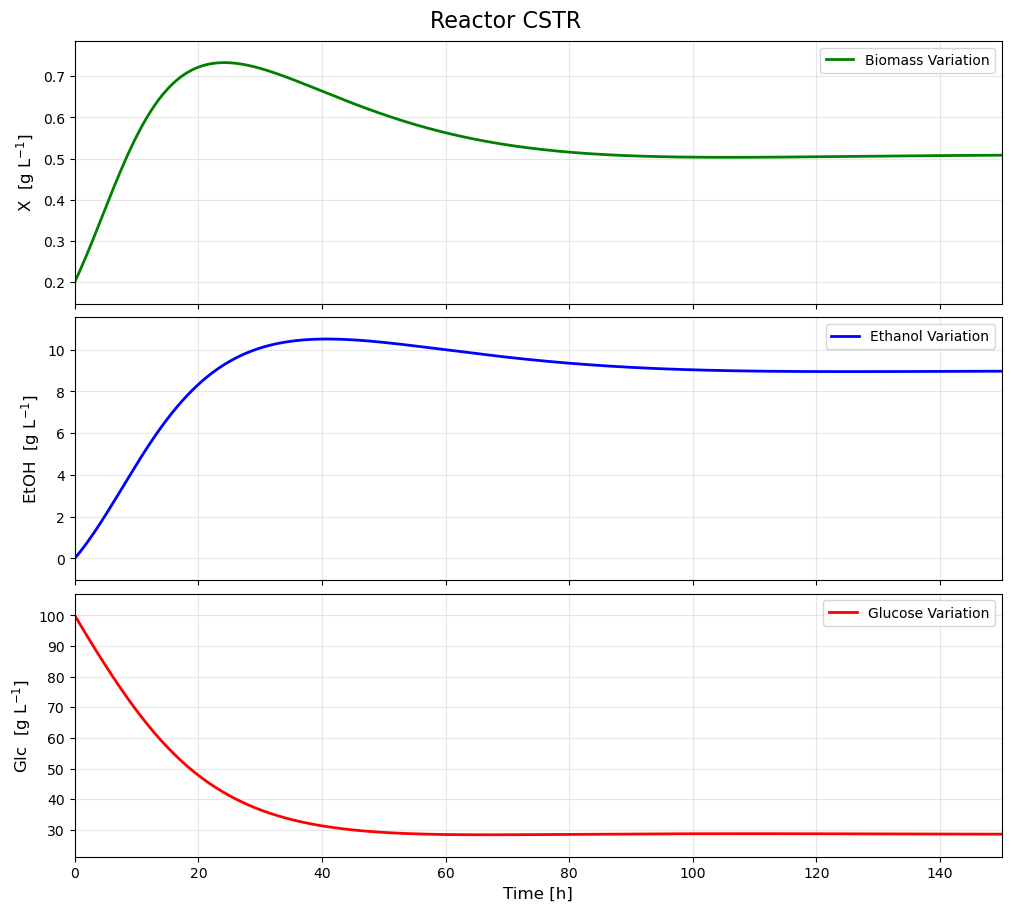

In [ ]:
# Graficamos los resultados:
# Serie: (título/leyenda, datos_y, color, etiqueta_y)
series = [
    ('Biomass Variation', X_sol,  'green', r'X  [g L$^{-1}$]'),
    ('Ethanol Variation', EtOH_sol,'blue',  r'EtOH  [g L$^{-1}$]'),
    ('Glucose Variation', Glc_sol,'red',   r'Glc  [g L$^{-1}$]'),
]

# Pueden agregar también los otros estados para ver su comportamiento

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 9), constrained_layout=True)

for ax, (name, y, color, ylab) in zip(axes, series):
    y = np.asarray(y)
    ax.plot(time, y, color=color, lw=2, label=name)

    ymin, ymax = np.nanmin(y), np.nanmax(y)
    if np.isclose(ymin, ymax):
        dy = 1.0 if ymax == 0 else 0.1*abs(ymax)
        ymin, ymax = ymin - dy, ymax + dy
    else:
        pad = 0.10*(ymax - ymin)
        ymin, ymax = ymin - pad, ymax + pad
    ax.set_ylim(ymin, ymax)

    ax.set_ylabel(ylab, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)

axes[-1].set_xlabel('Time [h]', fontsize=12)
axes[-1].set_xlim(np.min(time), np.max(time))
fig.suptitle(r'Reactor CSTR', fontsize=16)
plt.show()

In [ ]:
t_last = time[-1]
y_last = np.array([X_sol[-1], EtOH_sol[-1], Glc_sol[-1]])   # [X, EtOH, Glc] al final
print("último punto:", t_last, y_last)

último punto: 150.0 [ 0.50825446  8.971266   28.56303704]
